In [1]:
import pandas as pd
import os
from hydra import compose, initialize
from omegaconf import OmegaConf
import numpy as np
from torch.utils.data import DataLoader
import torch
os.chdir('/home/yainoue/meg2image/codes/MEG-decoding')
import sys
sys.path.append('.')
from meg_ssl.dataclass import parse_dataset
from meg_ssl.models import get_model_and_trainer
from meg_ssl.models.sc_mbm.mae_for_eeg import eeg_encoder, classify_network, mapping
import matplotlib.pyplot as plt

class EvalSettings:
    trained_sbj = ['1'] # ['1', '3', '1_3']
    eval_sbj = ['1'] # ['1', '2', '3']
    num_samples = ['', '-10k', '-2.5k', '-1k'] #['', '-10k', '-5k', '-2.5k', '-1k'] # roi等の情報も含める場合がある
    num_samples = ['-roi_all' + s for s in num_samples]
    device = 'cuda'
    fs = 1000
    duration = 200
    roi = 'all' # 'frontal'# 'vc'
    # fss = [1000]
    # durations = [200]
    model_names = ['best'] # ['best', 'last'] # 'last'
    result_root = '../../results_ssl/'
    ckpt_pattern = 'sbj{sbj_name}/scmbm_{patch_size}-fs{fs}-dura{duration}{n_sample}/ckpt/{model_name}.pth'


class CFGBase():
    eval_dataset_name_dict ={
        '1': {'train':{'drama': 'sbj_1-session_1'},
              'val': {'GOD': 'sbj_1-train-session_6_12'}},
        '2': {'train':{'drama': 'sbj_1-session_1'}, # dummy
              'val': {'GOD': 'sbj_2-train-session_6_12'}},
        '3': {'train':{'drama': 'sbj_3-session_1'},
              'val': {'GOD': 'sbj_3-train-session_6_12'}}
    }
    h5_root_dict = {
        '1': '../../../dataset/ssl_dataset/sbj1/{roi}-fs{fs}-dura{duration}-1',
        '2': '../../../dataset/ssl_dataset/sbj2/', # None
        '3': '../../../dataset/ssl_dataset/sbj3/sbj3-{roi}-fs{fs}-dura{duration}-1'
    }
    dataset_yaml_names_dict = {
        '1-vc': {'drama': 'drama/drama_vc.yaml', 'GOD': 'GOD/god_vc.yaml'},
        '2-vc': {'drama': 'drama/drama_vc.yaml', 'GOD': 'GOD/god_vc.yaml'},
        '3-vc': {'drama': 'drama/drama_vc.yaml', 'GOD': 'GOD/god_vc.yaml'},
        '1-frontal': {'drama': 'drama/drama_frontal.yaml', 'GOD': 'GOD/god_frontal.yaml'},
        '2-frontal': {'drama': 'drama/drama_frontal.yaml', 'GOD': 'GOD/god_frontal.yaml'},
        '3-frontal': {'drama': 'drama/drama_frontal.yaml', 'GOD': 'GOD/god_frontal.yaml'},
        '1-all': {'drama': 'drama/drama_config.yaml', 'GOD': 'GOD/god_config.yaml'},
        '2-all': {'drama': 'drama/drama_config.yaml', 'GOD': 'GOD/god_config.yaml'},
        '3-all': {'drama': 'drama/drama_config.yaml', 'GOD': 'GOD/god_config.yaml'},
    }
    total_limit_dict = {
        '1': {'train': {'drama': 100}, 'val': {'GOD': 1200}},
        '2': {'train': {'drama': 100}, 'val': {'GOD': 1200}},
        '3': {'train': {'drama': 100}, 'val': {'GOD': 1200}},
    }


    def __init__(self, sbj_name:str, roi, fs, duration):
        self.dataset_name =self.eval_dataset_name_dict[sbj_name]
        self.total_limit = self.total_limit_dict[sbj_name]

        self.h5_root = self.h5_root_dict[sbj_name].format(roi=roi, fs=fs, duration=duration)
        self.dataset_yaml = self.dataset_yaml_names_dict[f'{sbj_name}-{roi}']

        with initialize(config_path="../meg_ssl/ssl_configs/preprocess"):
            self.preprocess = compose(config_name=f'fs{fs}_dura{duration}')


def get_config(config_name):
    with initialize(config_path="../meg_ssl/ssl_configs"):
        cfg = compose(config_name=config_name)
    print('read config: ', config_name)

    cfg.training.logdir = 'tmps/eval/log_dummy'
    cfg.training.ckpt_dir = 'tmps/eval/ckpt_dummy'
    cfg.training.reconst_fig_dir = 'tmps/eval/reconst_dummy'
    return cfg


def get_dataset(cfg):
    dataset_names:dict = cfg.dataset_name
    # import pdb; pdb.set_trace()
    dataset_yamls:dict = cfg.dataset_yaml
    num_trial_limit:dict = cfg.total_limit
    preproc_config:OmegaConf = cfg.preprocess
    h5_root:str = cfg.h5_root
    image_preprocs:list = []
    meg_preprocs:list = []
    only_meg:bool = True
    on_memory:bool = True #False
    dataset_dict:dict = parse_dataset(dataset_names, dataset_yamls, preproc_config, num_trial_limit,
                                      h5_root, image_preprocs, meg_preprocs, only_meg, on_memory)

    return dataset_dict['train'], dataset_dict['val']


def get_model_and_trainer_from_cfg(cfg):
    meg_encoder, trainer = get_model_and_trainer(cfg, device_count=1, usewandb=False, only_model=False)
    return meg_encoder, trainer


def first_setting(cfg, fs, duration, manual_setting=True):
    with initialize(config_path="../meg_ssl/ssl_configs/preprocess"):
        cfg.preprocess = compose(config_name=f'fs{fs}_dura{duration}')

    if manual_setting:
        cfg.model.parameters.time_len = 208
        cfg.model.parameters.in_chans = 22 #145 # 36 # 22
    else:
        # get dataset
        train_dataset, _ = get_dataset(cfg)

        # cfg tuning
        cfg.model.parameters.time_len = int(np.floor(cfg.preprocess.meg_duration * cfg.preprocess.brain_resample_rate))
        cfg.model.parameters.in_chans = train_dataset.datasets[0].num_electrodes
        print('first settings: time_len', cfg.model.parameters.time_len)
        print('first settings: in_chans', cfg.model.parameters.in_chans)
    return cfg

def eval_one_condition(dataloader, model, trainer, device):
    model.eval()
    model.to(device)
    trainer.device = device
    trainer.model = model
    trainer.val_loader = dataloader

    # evaluation
    print('=================start evaluation================')
    ret = trainer.validation(epoch=0)
    print('VAL/ loss:{:.3f},  corr:{:.3f}'.format(ret['val_loss'], ret['val_corr']))
    return ret

def validation(model, data_loader)->dict:
    model.eval()
    val_loss = []
    val_corr = []
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            pred, loss, corr = reconst(step, batch)
            val_loss.append(loss)
            val_corr.append(corr)
    print('val loss: {}, val_corr: {}'.format(np.mean(val_loss), np.mean(val_corr)))
    return {'val_loss': np.mean(val_loss), 'val_corr':np.mean(val_corr)}

def reconst(model, batch, mask_ratio):
    samples = batch
    img_features = None
    valid_idx = None
    samples = samples.to('cuda')
    with torch.cuda.amp.autocast(enabled=True):
        loss, pred, _ = model(samples, img_features, valid_idx=valid_idx, mask_ratio=mask_ratio)

    loss_value = loss.item()

    pred = pred.to('cpu').detach()
    samples = samples.to('cpu').detach()
    
    pred = model.unpatchify(pred)
    cor = torch.mean(torch.tensor([torch.corrcoef(torch.cat([p[0].unsqueeze(0), s[0].unsqueeze(0)],axis=0))[0,1] for p, s in zip(pred, samples)])).item()
    return pred, loss_value, cor

def reconst_from_encoder(model, batch, original_model):
    
    samples = batch
    img_features = None
    valid_idx = None
    samples = samples.to('cuda')
    with torch.cuda.amp.autocast(enabled=True):
        # latent_original, mask, ids_restore = original_model.forward_encoder(samples, mask_ratio=0.0)
        
        latent = model(samples)
        pred = original_model.forward_decoder(latent, None)
    pred = pred.to('cpu').detach()
    samples = samples.to('cpu').detach()
    
    pred = original_model.unpatchify(pred)
    return pred

def run(settings):
    roi = settings.roi # 'vc'
    fs = settings.fs #1000
    dura = settings.duration # 200
    device = settings.device

    # get model
    model_base_cfg = get_config('sbj1_1k') # dummy
    model_base_cfg = first_setting(model_base_cfg, fs, dura)
    model, trainer = get_model_and_trainer_from_cfg(model_base_cfg)

    df= {'eval_sbj': [], 'trained_sbj': [], 'model_name': [], 'n_sample': [], 'val_loss': [], 'val_corr': []}
    for e_sub in settings.eval_sbj:
        # get dataset for validation
        eval_sub_cfg = CFGBase(e_sub, roi, fs, dura)
        train_dataset, val_dataset = get_dataset(eval_sub_cfg)
        # TODO: train_datasetだけ値が安定しない問題。。→jitterが強制的に入っている
        # 1: train_dataset[0].sum()= 193.4513 val_dataset[0].sum()=-342.68982
        # 2: train_dataset[0].sum()= 193.4513 val_dataset[0].sum()=-267.06232
        # 3: train_dataset[0].sum()= 44.667725 val_dataset[0].sum()= 259.26093
        print('Eval Sbj: ', e_sub)
        # print('deterministic: ', train_dataset.datasets[0].deterministic)
        # train_dataset.datasets[0].deterministic = True
        # import pdb; pdb.set_trace()
        # import pdb; pdb.set_trace()
        val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)
        for t_sub in settings.trained_sbj:
            for n_sample in settings.num_samples:
                for model_name in settings.model_names:
                    #  'sbj{sbj_name}/scmbm_{patch_size}-fs{fs}-dura{duration}/ckpt/{model_name}{n_sample}.pth'
                    ckpt_filename = settings.ckpt_pattern.format(sbj_name=t_sub, patch_size=4, fs=fs, duration=dura, model_name=model_name, n_sample=n_sample)
                    ckpt_path = os.path.join(settings.result_root, ckpt_filename)
                    print('load weight from ', ckpt_path)
                    model.load_state_dict(torch.load(ckpt_path))
                    ret = eval_one_condition(val_dataloader, model, trainer, device)

#                     df['eval_sbj'].append(e_sub)
#                     df['trained_sbj'].append(t_sub)
#                     df['model_name'].append(model_name)
#                     df['n_sample'].append(n_sample)
#                     for key, value in ret.items():
#                         df[key].append(value)


#     result_save_dir = os.path.join(settings.result_root, 'vis_scalings')
#     os.makedirs(result_save_dir, exist_ok=True)
#     savepath = os.path.join(result_save_dir, '{roi}-{fs}-{dura}-{sbj_list}.csv'.format(roi=roi, fs=fs, dura=dura, sbj_list='_'.join(settings.eval_sbj)))

#     df = pd.DataFrame(df)
#     df.to_csv(savepath)
#     print('DataFrame is saved to ', savepath)



/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
t_sub = '1'
e_sub = '1'
fs = 1000
dura = 200
model_name = 'last'
n_sample = ''
settings = EvalSettings()
roi ='vc'  # settings.roi # 'vc'
device = 'cuda'

# get model
model_base_cfg = get_config('sbj1_1k') # dummy
# model_base_cfg = first_setting(model_base_cfg, fs, dura)
with initialize(config_path="../meg_ssl/ssl_configs/preprocess"):
    model_base_cfg.preprocess = compose(config_name=f'fs{fs}_dura{dura}')
model_base_cfg.model.parameters.time_len = 208
model_base_cfg.model.parameters.in_chans = 22 #145 # 36 # 22

model, trainer = get_model_and_trainer_from_cfg(model_base_cfg)
encoder_model = eeg_encoder(time_len=208, patch_size=model_base_cfg.model.parameters.patch_size, embed_dim=model_base_cfg.model.parameters.embed_dim, in_chans=model_base_cfg.model.parameters.in_chans,
                depth=model_base_cfg.model.parameters.depth, num_heads=model_base_cfg.model.parameters.num_heads, mlp_ratio=model_base_cfg.model.parameters.mlp_ratio, global_pool=False) 

eval_sub_cfg = CFGBase(e_sub, roi, fs, dura)
train_dataset, val_dataset = get_dataset(eval_sub_cfg)

ckpt_filename = settings.ckpt_pattern.format(sbj_name=t_sub, patch_size=4, fs=fs, duration=dura, model_name=model_name, n_sample=n_sample)
ckpt_path = os.path.join(settings.result_root, ckpt_filename)
print('load weight from ', ckpt_path)
model.load_state_dict(torch.load(ckpt_path))
encoder_model.load_checkpoint(torch.load(ckpt_path))

model.cuda().eval()
encoder_model.cuda().eval()

/tmp/ipykernel_180120/1370113258.py:76: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../meg_ssl/ssl_configs"):
/home/yainoue/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'sbj1_1k': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_180120/3098327484.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../meg_ssl/ssl_configs/preprocess"):


read config:  sbj1_1k
logger file is  tmps/eval/log_dummy/2023-09-05 15:28:33.199570


/tmp/ipykernel_180120/1370113258.py:71: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../meg_ssl/ssl_configs/preprocess"):
/home/yainoue/meg2image/codes/MEG-decoding/meg_ssl/dataclass/__init__.py:27: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../ssl_configs/dataset"):


=================drama=================
sbj_1-session_1
dataset_info_list:  [{'meg_path': '/work/project/MEG_GOD/GOD_dataset/VideoWatching/preprocess_MEG/sbj01/ID01_HerosVol1-1_id1_MEG_DATAPixx_part2.mat', 'movie_path': '/storage/dataset/MEG/internal/AnnotatedMovie_v1/tmp/stim_video/ID01_HerosVol1-1_id1_MEG_DATAPixx_part2.mp4', 'movie_trigger_path': '/home/yainoue/meg2image/codes/MEG-decoding/data/movies/video1-part2_onset_triggers.csv', 'meg_trigger_path': '/home/yainoue/meg2image/codes/matlab_codes/triggers/sbj01/onset_trigger_video_1-part_2.csv', 'sbj_name': 'sbj01', 'h5_file_name': '../../../dataset/ssl_dataset/sbj1/vc-fs1000-dura200-1/drama/sbj01_ID01_HerosVol1-1_id1_MEG_DATAPixx_part2.mp4.h5', 'split': 'train', 'movie_crop_pts': [[297, 528], [783, 1392]]}]
VIDEO FPS:  29.97002997002997
ROI:  ['occipital/left', 'occipital/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 

eeg_encoder(
  (patch_embed): PatchEmbed1D(
    (proj): Conv1d(22, 1024, kernel_size=(4,), stride=(4,))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1024, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fal

In [3]:
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)
for original_batch in val_dataloader:
    break

0.22588549554347992 0.8067899346351624


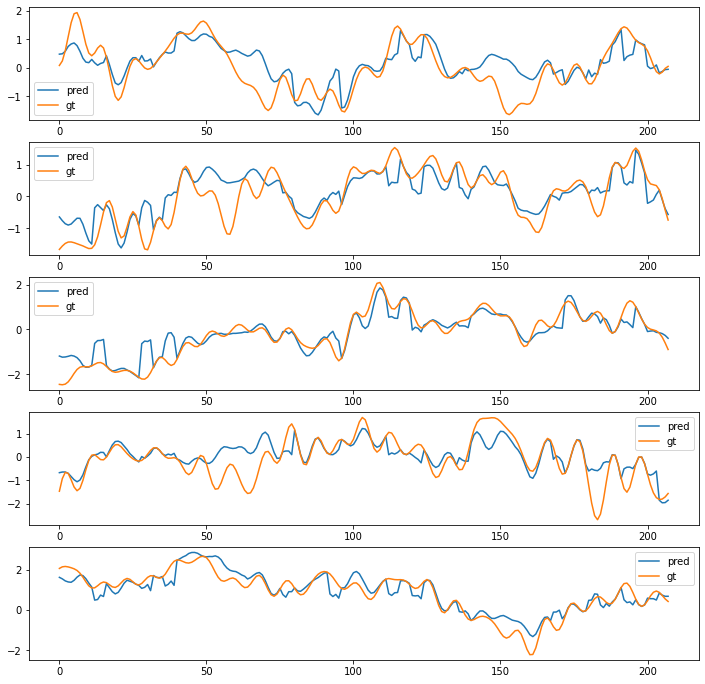

In [4]:
pred, loss, corr = reconst(model, original_batch, mask_ratio=0.75)
print(loss, corr)
fig, axes = plt.subplots(nrows=5, figsize=(12, 12))
pred = pred.detach().cpu().numpy()
batch = original_batch.detach().cpu().numpy()
x = np.arange(pred.shape[-1])
for i in range(5):
    axes[i].plot(x, pred[0,i,:], label='pred')
    axes[i].plot(x, batch[0,i,:], label='gt')
    axes[i].legend()
plt.show()

0.0 0.949916422367096


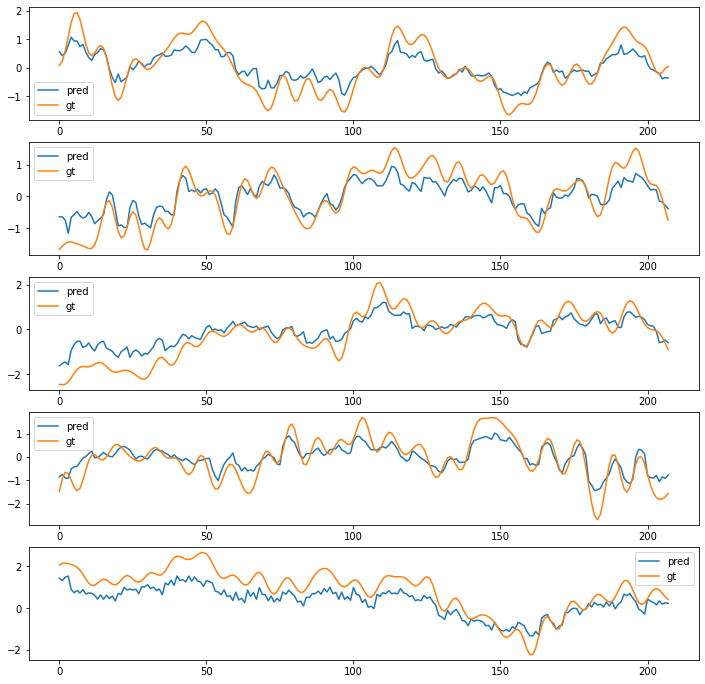

In [5]:
pred, loss, corr = reconst(model, original_batch, mask_ratio=0.0)
print(loss, corr)
fig, axes = plt.subplots(nrows=5, figsize=(12, 12))
pred = pred.detach().cpu().numpy()
batch = original_batch.detach().cpu().numpy()
x = np.arange(pred.shape[-1])
for i in range(5):
    axes[i].plot(x, pred[0,i,:], label='pred')
    axes[i].plot(x, batch[0,i,:], label='gt')
    axes[i].legend()
plt.show()

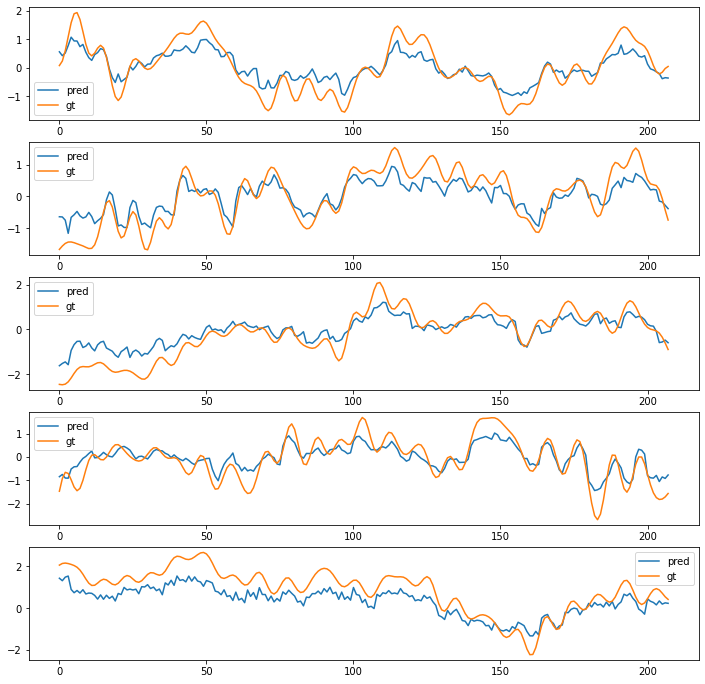

In [6]:
pred = reconst_from_encoder(encoder_model, original_batch, model)

fig, axes = plt.subplots(nrows=5, figsize=(12, 12))
pred = pred.detach().cpu().numpy()
batch = original_batch.detach().cpu().numpy()
x = np.arange(pred.shape[-1])
for i in range(5):
    axes[i].plot(x, pred[0,i,:], label='pred')
    axes[i].plot(x, batch[0,i,:], label='gt')
    axes[i].legend()
plt.show()

In [7]:
samples = original_batch
img_features = None
valid_idx = None
samples = samples.to('cuda')
with torch.cuda.amp.autocast(enabled=True):
    latent_original, mask, ids_restore = model.forward_encoder(samples, mask_ratio=-1)

    latent = encoder_model(samples)
    pred = model.forward_decoder(latent, ids_restore_dummy)
pred = pred.to('cpu').detach()
samples = samples.to('cpu').detach()

pred = model.unpatchify(pred)

NameError: name 'ids_restore_dummy' is not defined

In [23]:
print(latent_original.shape, latent_original.sum())
print(latent.shape, latent.sum())

torch.Size([32, 53, 1024]) tensor(-9097.1641, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([32, 53, 1024]) tensor(-9097.1641, device='cuda:0', grad_fn=<SumBackward0>)


In [26]:
ids_restore_dummy.shape

torch.Size([32, 52])

In [13]:
encoder_model.norm

LayerNorm((1024,), eps=1e-05, elementwise_affine=True)

In [14]:
latent_original - latent

tensor([[[-2.6420e-05, -9.9860e-05,  6.2078e-05,  ...,  5.0366e-06,
           2.8940e-05, -3.2023e-05],
         [ 9.7584e-01,  6.3690e-01, -2.6228e-01,  ..., -1.7707e+00,
           5.7811e-01,  4.7782e-02],
         [-2.2550e-01, -1.0190e-01, -4.5395e-01,  ..., -1.8304e+00,
          -4.0730e-01, -3.9076e-01],
         ...,
         [ 6.3233e-01,  6.1842e-01,  6.1957e-02,  ...,  1.0757e+00,
           6.3556e-02,  1.6974e-01],
         [-9.2883e-03,  5.8744e-02, -1.6730e-01,  ..., -2.2529e-03,
          -1.4963e-02, -1.8953e-01],
         [-5.0633e-01, -1.4354e-02,  2.9447e-01,  ...,  6.7310e-01,
           5.8034e-02, -3.6484e-01]],

        [[ 2.7746e-05, -1.4454e-04,  1.7442e-05,  ..., -4.0770e-05,
           9.6828e-05,  6.1133e-05],
         [ 4.5914e-01,  8.7725e-01,  7.1226e-01,  ..., -1.4585e+00,
           7.9227e-02, -6.0071e-01],
         [ 5.2954e-01,  9.3503e-01,  7.0787e-02,  ..., -1.4158e+00,
           4.5869e-01,  5.4031e-02],
         ...,
         [ 1.0362e+00,  9

In [22]:
state_dict_encoder = encoder_model.state_dict()
state_dict_original = model.state_dict()
for key in state_dict_encoder.keys():
    val1 = state_dict_encoder[key]
    val2 = state_dict_original[key]
    if key == 'mask_token':
        continue
    #     print(key)
    flag = (val1==val2).detach().cpu().numpy().all()
    if not flag:
        print(key, flga)

In [ ]:
# CLS token なし

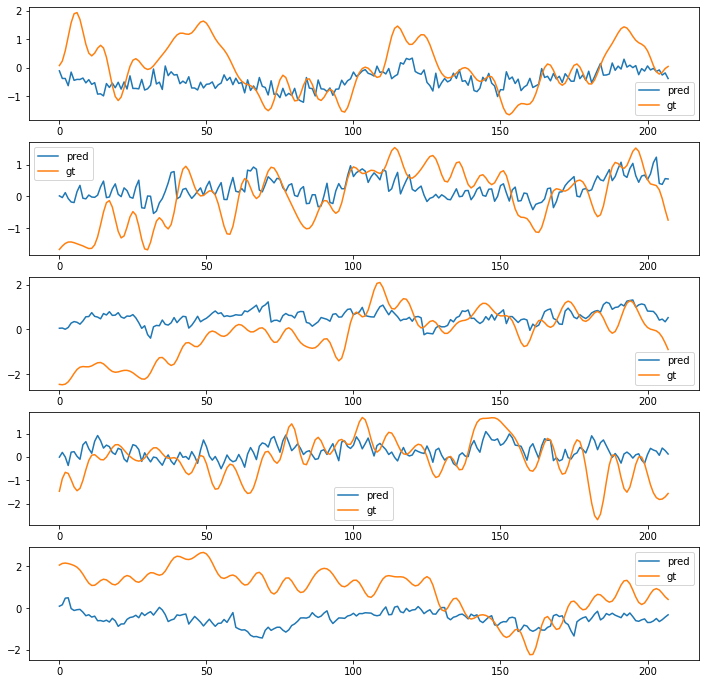

In [55]:
pred = reconst_from_encoder(encoder_model, original_batch, model)

fig, axes = plt.subplots(nrows=5, figsize=(12, 12))
pred = pred.detach().cpu().numpy()
batch = original_batch.detach().cpu().numpy()
x = np.arange(pred.shape[-1])
for i in range(5):
    axes[i].plot(x, pred[0,i,:], label='pred')
    axes[i].plot(x, batch[0,i,:], label='gt')
    axes[i].legend()
plt.show()